# Visualize Splines

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def visualize_rve_shaded_single_color(all_splines, grid_bounds, shape_color="#939598", background_color="#C8C9CB", alpha=1.0):
    """
    Visualizes the RVE with all splines stored in the all_splines list,
    shading the insides of the splines with a single specified color and a custom background color.
    There are no outlines for the shapes.

    Parameters:
        all_splines (list of pd.DataFrame): List of DataFrames representing all splines added so far.
        grid_bounds (tuple): The dimensions of the RVE grid as (grid_rows, grid_columns).
        shape_color (str): Color for shading the insides of the splines.
        background_color (str): Color for the background outside the shapes.
        alpha (float): The transparency level for the shaded areas (0 is fully transparent, 1 is fully opaque).
    """
    grid_rows, grid_columns = grid_bounds

    # Create a new plot with the specified background color
    plt.figure(figsize=(10, 10))
    plt.gca().set_facecolor(background_color)
    
    # Set up the plot limits based on the grid bounds
    plt.xlim(0, grid_columns)
    plt.ylim(0, grid_rows)
    
    # Invert the Y-axis for proper alignment with grid coordinates
    plt.gca().invert_yaxis()

    patches = []  # Collect all spline polygons for efficient plotting

    # Plot each spline in the RVE
    for spline_data in all_splines:
        x = spline_data['x'].values
        y = spline_data['y'].values

        # Create a polygon for the spline
        polygon = Polygon(list(zip(x, y)), closed=True)
        patches.append(polygon)

    # Add all spline polygons to the plot with the specified shape color
    patch_collection = PatchCollection(patches, facecolor=shape_color, edgecolor="none", alpha=alpha)
    plt.gca().add_collection(patch_collection)

    # Remove ticks
    plt.xticks([])  # Disable xticks
    plt.yticks([])  # Disable yticks

    # Show the plot
    plt.show()

# Scale down splines slightly at the end

In [2]:
import pandas as pd

def scale_down_spline(spline_data, scaling_factor):
    """
    Scales down a single spline by a constant factor from its centroid.
    
    Parameters:
        spline_data (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        scaling_factor (float): The factor by which to scale the spline (0 < scaling_factor < 1).
    
    Returns:
        pd.DataFrame: The scaled-down spline coordinates ['x', 'y'].
    """
    # Ensure scaling factor is valid
    if scaling_factor <= 0 or scaling_factor >= 1:
        raise ValueError("Scaling factor must be between 0 and 1.")

    # Remove the last point if it's identical to the first (closed spline)
    if (spline_data.iloc[0]['x'] == spline_data.iloc[-1]['x'] and
        spline_data.iloc[0]['y'] == spline_data.iloc[-1]['y']):
        valid_spline_data = spline_data.iloc[:-1]
    else:
        valid_spline_data = spline_data

    # Compute the centroid
    centroid_x = valid_spline_data['x'].mean()
    centroid_y = valid_spline_data['y'].mean()

    # Scale the coordinates
    scaled_spline = spline_data.copy()
    scaled_spline['x'] = centroid_x + (spline_data['x'] - centroid_x) * scaling_factor
    scaled_spline['y'] = centroid_y + (spline_data['y'] - centroid_y) * scaling_factor

    return scaled_spline


def create_scaled_down_all_splines(all_splines, scaling_factor):
    """
    Creates a scaled-down version of all_splines by applying the scaling factor to each spline.
    
    Parameters:
        all_splines (list of pd.DataFrame): List of splines represented as DataFrames.
        scaling_factor (float): The factor by which to scale each spline (0 < scaling_factor < 1).
    
    Returns:
        list of pd.DataFrame: List of scaled-down splines.
    """
    scaled_down_all_splines = []
    for spline_data in all_splines:
        scaled_down_spline = scale_down_spline(spline_data, scaling_factor)
        scaled_down_all_splines.append(scaled_down_spline)
    
    return scaled_down_all_splines

# Binarize RVE Grid from RVE Grid

In [3]:
import numpy as np

def create_binary_rve(rve_grid):
    """
    Creates a binary version of the RVE grid.
    0s remain as 0, and non-zeros are converted to 1.

    Parameters:
        rve_grid (np.ndarray): The original RVE grid.

    Returns:
        np.ndarray: Binary version of the RVE grid.
    """
    binary_rve_copy = np.where(rve_grid == 0, 0, 1)
    return binary_rve_copy

# Segment Splines based on Periodicity

In [4]:
def separate_splines(all_splines, grid_rows, grid_cols):
    """
    Separates splines into periodic and non-periodic based on their coordinates.

    Parameters:
        all_splines (list of pd.DataFrame): List of splines, each represented as a DataFrame.
        grid_rows (int): Number of rows in the RVE grid.
        grid_cols (int): Number of columns in the RVE grid.

    Returns:
        tuple: (list of periodic splines, list of non-periodic splines)
    """
    periodic_splines = []
    non_periodic_splines = []

    for spline in all_splines:
        if is_periodic(spline, grid_rows, grid_cols):
            periodic_splines.append(spline)
        else:
            non_periodic_splines.append(spline)

    return periodic_splines, non_periodic_splines

def is_periodic(spline, grid_rows, grid_cols):
    """
    Determines if a spline is periodic by checking if any of its points exceed the grid boundaries.

    Parameters:
        spline (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        grid_rows (int): Number of rows in the RVE grid.
        grid_cols (int): Number of columns in the RVE grid.

    Returns:
        bool: True if the spline is periodic, False otherwise.
    """
    return (
        spline['x'].max() >= grid_cols or spline['y'].max() >= grid_rows or
        spline['x'].min() < 0 or spline['y'].min() < 0
    )

# Sort Splines According to X

In [5]:
def sort_non_periodic_splines(non_periodic_splines):
    """
    Sorts non-periodic splines in descending order of centroid x-coordinate.

    Parameters:
        non_periodic_splines (list of pd.DataFrame): List of non-periodic splines.

    Returns:
        list of pd.DataFrame: Sorted list of non-periodic splines.
    """
    def calculate_centroid(spline):
        """
        Calculates the centroid of a spline, excluding the last point if it's identical to the first.
        """
        # Remove the last point if it duplicates the first
        if (spline.iloc[0]['x'] == spline.iloc[-1]['x'] and
            spline.iloc[0]['y'] == spline.iloc[-1]['y']):
            spline = spline.iloc[:-1]
        
        # Compute centroid
        centroid_x = spline['x'].mean()
        return centroid_x

    # Sort the splines by centroid x-coordinate in descending order
    sorted_splines = sorted(non_periodic_splines, key=calculate_centroid, reverse=True)

    return sorted_splines

# Sort Splines according to Y

In [6]:
def sort_non_periodic_splines_by_y(non_periodic_splines):
    """
    Sorts non-periodic splines in descending order of centroid y-coordinate.

    Parameters:
        non_periodic_splines (list of pd.DataFrame): List of non-periodic splines.

    Returns:
        list of pd.DataFrame: Sorted list of non-periodic splines.
    """
    def calculate_centroid_y(spline):
        """
        Calculates the centroid y-coordinate of a spline, excluding the last point if it's identical to the first.
        """
        # Remove the last point if it duplicates the first
        if (spline.iloc[0]['x'] == spline.iloc[-1]['x'] and
            spline.iloc[0]['y'] == spline.iloc[-1]['y']):
            spline = spline.iloc[:-1]
        
        # Compute centroid y
        centroid_y = spline['y'].mean()
        return centroid_y

    # Sort the splines by centroid y-coordinate in descending order
    sorted_splines = sorted(non_periodic_splines, key=calculate_centroid_y, reverse=True)

    return sorted_splines

# Mark Points inside Spline as Unoccupied

In [7]:
from matplotlib.path import Path
import numpy as np

def mark_spline_on_grid(binary_rve_copy, spline_coords):
    """
    Updates the binary RVE grid by marking grid points inside a given spline as 0.

    Parameters:
        binary_rve_copy (np.ndarray): Binary version of the RVE grid (1 = free, 0 = occupied).
        spline_coords (pd.DataFrame): Coordinates of the spline (columns: ['x', 'y']).

    Returns:
        np.ndarray: Updated binary RVE grid.
    """
    # Get grid dimensions
    grid_rows, grid_cols = binary_rve_copy.shape

    # Generate all grid points
    x_coords, y_coords = np.meshgrid(np.arange(grid_cols), np.arange(grid_rows))
    grid_points = np.vstack((x_coords.ravel(), y_coords.ravel())).T

    # Create a Path for the spline
    spline_path = Path(spline_coords[['x', 'y']].values)

    # Identify grid points inside the spline
    inside_mask = spline_path.contains_points(grid_points)

    # Update the binary RVE grid: mark inside points as 0
    binary_rve_copy.ravel()[inside_mask] = 1

    return binary_rve_copy

# Shift Spline in X

In [8]:
def shift_spline_x(spline_coords, shift_value=1):
    """
    Shifts all points of a spline by a specified value in the x-direction.

    Parameters:
        spline_coords (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        shift_value (int or float): The amount to shift the x-coordinates. Default is 1.

    Returns:
        pd.DataFrame: Updated spline coordinates after the shift.
    """
    shifted_spline_coords = spline_coords.copy()
    shifted_spline_coords['x'] += shift_value
    return shifted_spline_coords

# Shift Spline in Y

In [9]:
def shift_spline_y(spline_coords, shift_value=1):
    """
    Shifts all points of a spline by a specified value in the y-direction.

    Parameters:
        spline_coords (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        shift_value (int or float): The amount to shift the y-coordinates. Default is 1.

    Returns:
        pd.DataFrame: Updated spline coordinates after the shift.
    """
    shifted_spline_coords = spline_coords.copy()
    shifted_spline_coords['y'] += shift_value
    return shifted_spline_coords

# Check Spline Intersection

In [10]:
from matplotlib.path import Path
import numpy as np

def check_spline_intersection(spline_coords, binary_rve_copy):
    """
    Checks if a spline intersects with any occupied points (0s) in the binary RVE grid.

    Parameters:
        spline_coords (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        binary_rve_copy (np.ndarray): Binary RVE grid (0 = occupied, 1 = free).

    Returns:
        bool: True if there is an intersection (any grid point inside the spline is 0),
              False otherwise.
    """
    # Get grid dimensions
    grid_rows, grid_cols = binary_rve_copy.shape

    # Generate all grid points
    x_coords, y_coords = np.meshgrid(np.arange(grid_cols), np.arange(grid_rows))
    grid_points = np.vstack((x_coords.ravel(), y_coords.ravel())).T

    # Create a Path for the spline
    spline_path = Path(spline_coords[['x', 'y']].values)

    # Identify grid points inside the spline
    inside_mask = spline_path.contains_points(grid_points)

    # Check if any grid points inside the spline are 0
    if np.any(binary_rve_copy.ravel()[inside_mask] == 0):
        return True  # Intersection detected

    return False  # No intersection

# Mark Spline Insides as Occupied

In [11]:
from matplotlib.path import Path
import numpy as np

def mark_spline_as_occupied(spline_coords, binary_rve_copy):
    """
    Marks every grid point inside the given spline as occupied (0) in the binary RVE grid.

    Parameters:
        spline_coords (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        binary_rve_copy (np.ndarray): Binary RVE grid (1 = free, 0 = occupied).

    Returns:
        np.ndarray: Updated binary RVE grid.
    """
    # Get grid dimensions
    grid_rows, grid_cols = binary_rve_copy.shape

    # Generate all grid points
    x_coords, y_coords = np.meshgrid(np.arange(grid_cols), np.arange(grid_rows))
    grid_points = np.vstack((x_coords.ravel(), y_coords.ravel())).T

    # Create a Path for the spline
    spline_path = Path(spline_coords[['x', 'y']].values)

    # Identify grid points inside the spline
    inside_mask = spline_path.contains_points(grid_points)

    # Mark grid points inside the spline as 0 (occupied)
    binary_rve_copy.ravel()[inside_mask] = 0

    return binary_rve_copy

# Create Binary Grid from Spline List

In [12]:
from matplotlib.path import Path
import numpy as np

def create_binary_grid(all_splines, grid_rows, grid_cols):
    """
    Creates a binary grid where 0 indicates points inside any spline and 1 indicates points outside.

    Parameters:
        all_splines (list of pd.DataFrame): List of DataFrames representing spline coordinates ['x', 'y'].
        grid_rows (int): Number of rows in the grid.
        grid_cols (int): Number of columns in the grid.

    Returns:
        np.ndarray: Binary grid with 0 indicating inside a spline and 1 indicating outside.
    """
    # Initialize the binary grid with ones
    binary_grid = np.ones((grid_rows, grid_cols), dtype=int)

    # Generate mesh grid points
    x_coords, y_coords = np.meshgrid(np.arange(grid_cols), np.arange(grid_rows))
    mesh_points = np.vstack((x_coords.ravel(), y_coords.ravel())).T

    # Iterate through each spline
    for spline_coords in all_splines:
        # Create a Path object for the current spline
        spline_path = Path(spline_coords[['x', 'y']].values)

        # Identify grid points inside the spline
        inside_mask = spline_path.contains_points(mesh_points)

        # Update binary grid: mark points inside the spline as 0
        binary_grid.ravel()[inside_mask] = 0

    return binary_grid

# Check if Moving Spline outside Bounding Box

In [13]:
def is_outside_bounding_box(spline_coords, grid_rows, grid_cols):
    """
    Checks if any point in the spline exceeds the RVE bounding box.

    Parameters:
        spline_coords (pd.DataFrame): DataFrame containing spline coordinates ['x', 'y'].
        grid_rows (int): Number of rows in the RVE grid.
        grid_cols (int): Number of columns in the RVE grid.

    Returns:
        bool: True if any point in the spline exceeds the bounding box, False otherwise.
    """
    # Check if any x-coordinate exceeds the grid columns or is negative
    exceeds_x_bounds = (spline_coords['x'] < 0).any() or (spline_coords['x'] >= grid_cols).any()

    # Check if any y-coordinate exceeds the grid rows or is negative
    exceeds_y_bounds = (spline_coords['y'] < 0).any() or (spline_coords['y'] >= grid_rows).any()

    # Return True if any coordinate is out of bounds
    return exceeds_x_bounds or exceeds_y_bounds

# Combine Splines into All Splines

In [14]:
def combine_splines(periodic_splines, non_periodic_splines):
    """
    Combines periodic splines and non-periodic splines into a single list.

    Parameters:
        periodic_splines (list of pd.DataFrame): List of periodic splines.
        non_periodic_splines (list of pd.DataFrame): List of non-periodic splines.

    Returns:
        list of pd.DataFrame: Combined list containing all splines.
    """
    # Combine the two lists
    combined_splines = periodic_splines + non_periodic_splines
    return combined_splines

# Import Spline Data from Excel

In [15]:
import pandas as pd

def import_splines_from_excel(file_name):
    """
    Reads spline data from an Excel file where each sheet represents a spline.
    Reconstructs the `all_splines` list.

    Parameters:
        file_name (str): The name of the Excel file containing spline data.

    Returns:
        list of pd.DataFrame: List of DataFrames, each representing a spline.
    """
    # Open the Excel file
    excel_data = pd.ExcelFile(file_name)
    
    # Initialize an empty list to hold the splines
    all_splines = []
    
    # Iterate through each sheet in the Excel file
    for sheet_name in excel_data.sheet_names:
        # Read the sheet into a DataFrame
        spline_data = pd.read_excel(excel_data, sheet_name=sheet_name)
        # Append the DataFrame to the list
        all_splines.append(spline_data)
    
    print(f"Spline data imported successfully from {file_name}")
    return all_splines

# MAIN PROGRAM

In [16]:
all_splines = import_splines_from_excel('Shaking Demonstration.xlsx')

Spline data imported successfully from Shaking Demonstration.xlsx


In [17]:
grid_rows = 500
grid_cols = 500

# Before Shaking

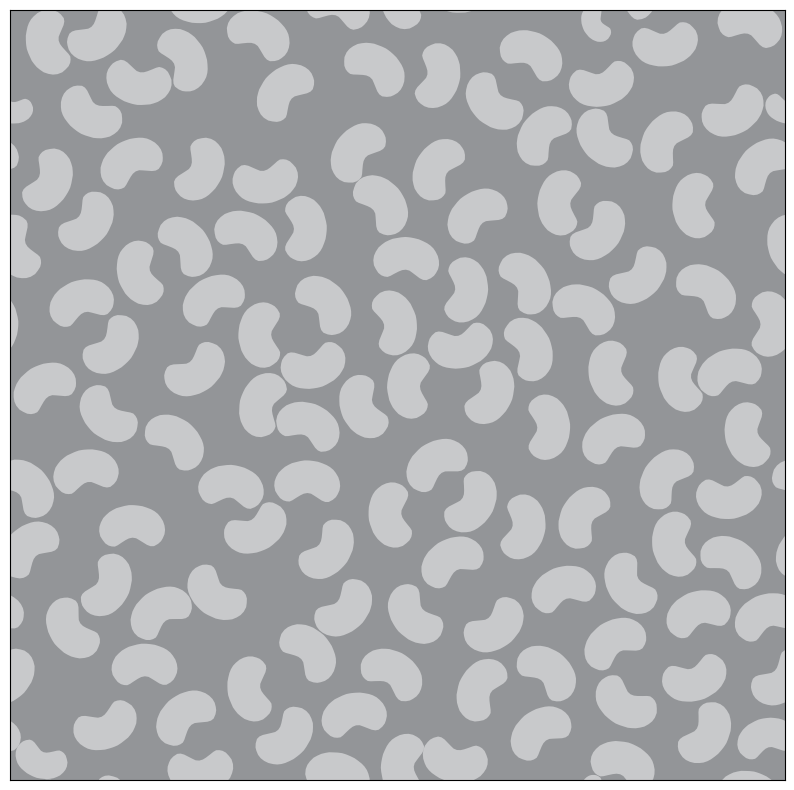

In [19]:
visualize_rve_shaded_single_color(all_splines, grid_bounds=(grid_rows, grid_cols), shape_color="#C8C9CB", background_color="#939598")

# Shake it towards the bottom right corner

In [20]:
periodic_splines, non_periodic_splines = separate_splines(all_splines, grid_rows, grid_cols)

In [21]:
binary_rve_copy = create_binary_grid(all_splines, grid_rows, grid_cols)
sorted_non_periodic_splines = sort_non_periodic_splines(non_periodic_splines)

In [22]:
shifted_non_periodic_splines = []
counter = 1
shift_increment = 2

for spline_coords in sorted_non_periodic_splines:
    
    binary_rve_copy = mark_spline_on_grid(binary_rve_copy, spline_coords)
    intersection = False
    exceeding_box = False
    movement = 0
    
    print("Starting Spline " + str(counter))
    
    while (not intersection) and (not exceeding_box): 
        spline_coords = shift_spline_x(spline_coords)
        intersection = check_spline_intersection(spline_coords, binary_rve_copy)
        movement = movement + shift_increment
        exceeding_box = is_outside_bounding_box(spline_coords, grid_rows, grid_cols)
        
    spline_coords = shift_spline_x(spline_coords, -1*shift_increment)
    binary_rve_copy = mark_spline_as_occupied(spline_coords, binary_rve_copy)
    
    print("Moved Spline " + str(counter) + " by "+ str(movement - shift_increment))
    
    shifted_non_periodic_splines.append(spline_coords)
    
    counter = counter + 1

Starting Spline 1
Moved Spline 1 by 18
Starting Spline 2
Moved Spline 2 by 2
Starting Spline 3
Moved Spline 3 by 20
Starting Spline 4
Moved Spline 4 by 18
Starting Spline 5
Moved Spline 5 by 6
Starting Spline 6
Moved Spline 6 by 20
Starting Spline 7
Moved Spline 7 by 12
Starting Spline 8
Moved Spline 8 by 8
Starting Spline 9
Moved Spline 9 by 36
Starting Spline 10
Moved Spline 10 by 30
Starting Spline 11
Moved Spline 11 by 6
Starting Spline 12
Moved Spline 12 by 24
Starting Spline 13
Moved Spline 13 by 30
Starting Spline 14
Moved Spline 14 by 48
Starting Spline 15
Moved Spline 15 by 14
Starting Spline 16
Moved Spline 16 by 34
Starting Spline 17
Moved Spline 17 by 28
Starting Spline 18
Moved Spline 18 by 60
Starting Spline 19
Moved Spline 19 by 36
Starting Spline 20
Moved Spline 20 by 102
Starting Spline 21
Moved Spline 21 by 38
Starting Spline 22
Moved Spline 22 by 22
Starting Spline 23
Moved Spline 23 by 54
Starting Spline 24
Moved Spline 24 by 66
Starting Spline 25
Moved Spline 25 by

In [23]:
shifted_non_periodic_splines = sort_non_periodic_splines_by_y(shifted_non_periodic_splines)

In [24]:
shifted_non_periodic_splines_both_axes = []
counter = 1
shift_increment = 2

for spline_coords in shifted_non_periodic_splines:
    
    binary_rve_copy = mark_spline_on_grid(binary_rve_copy, spline_coords)
    intersection = False
    exceeding_box = False
    movement = 0
    
    print("Starting Spline " + str(counter))
    
    while (not intersection) and (not exceeding_box): 
        spline_coords = shift_spline_y(spline_coords)
        intersection = check_spline_intersection(spline_coords, binary_rve_copy)
        movement = movement + shift_increment
        exceeding_box = is_outside_bounding_box(spline_coords, grid_rows, grid_cols)
        
    spline_coords = shift_spline_y(spline_coords, -1*shift_increment)
    binary_rve_copy = mark_spline_as_occupied(spline_coords, binary_rve_copy)
    
    print("Moved Spline " + str(counter) + " by "+ str(movement - shift_increment))
    
    shifted_non_periodic_splines_both_axes.append(spline_coords)
    
    counter = counter + 1

Starting Spline 1
Moved Spline 1 by 0
Starting Spline 2
Moved Spline 2 by 0
Starting Spline 3
Moved Spline 3 by 10
Starting Spline 4
Moved Spline 4 by 4
Starting Spline 5
Moved Spline 5 by 10
Starting Spline 6
Moved Spline 6 by 6
Starting Spline 7
Moved Spline 7 by 0
Starting Spline 8
Moved Spline 8 by 22
Starting Spline 9
Moved Spline 9 by 4
Starting Spline 10
Moved Spline 10 by 74
Starting Spline 11
Moved Spline 11 by 8
Starting Spline 12
Moved Spline 12 by 68
Starting Spline 13
Moved Spline 13 by 10
Starting Spline 14
Moved Spline 14 by 12
Starting Spline 15
Moved Spline 15 by 14
Starting Spline 16
Moved Spline 16 by 10
Starting Spline 17
Moved Spline 17 by 12
Starting Spline 18
Moved Spline 18 by 46
Starting Spline 19
Moved Spline 19 by 74
Starting Spline 20
Moved Spline 20 by 18
Starting Spline 21
Moved Spline 21 by 26
Starting Spline 22
Moved Spline 22 by 12
Starting Spline 23
Moved Spline 23 by 16
Starting Spline 24
Moved Spline 24 by 46
Starting Spline 25
Moved Spline 25 by 28


In [25]:
combined_splines = combine_splines(periodic_splines,shifted_non_periodic_splines_both_axes)

# After Shaking

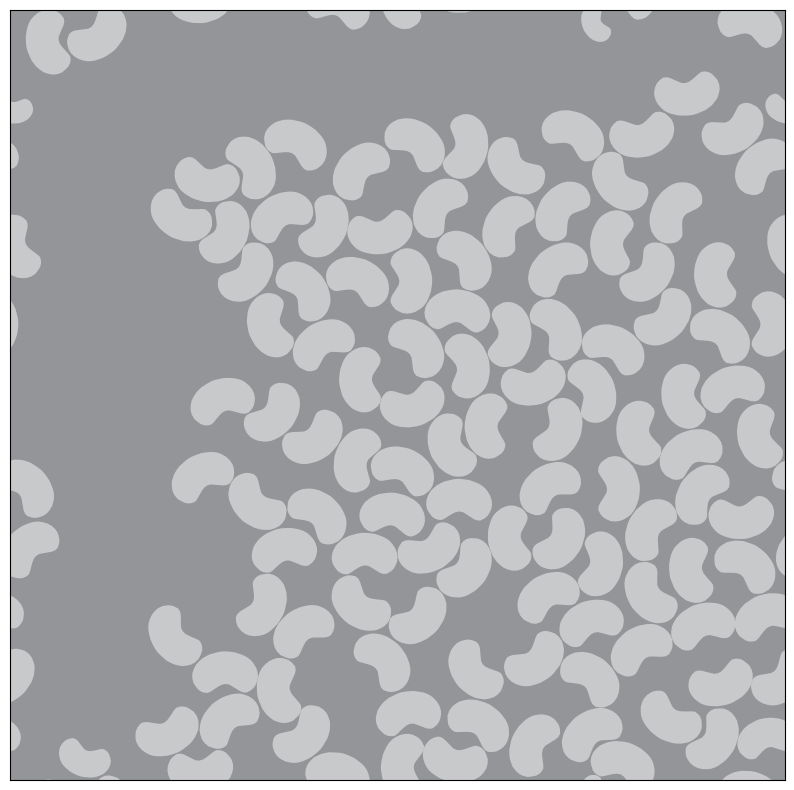

In [26]:
visualize_rve_shaded_single_color(combined_splines, grid_bounds=(grid_rows, grid_cols), shape_color="#C8C9CB", background_color="#939598")